# Практическая работа №6. Анализ метадинамики

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Запустила `gmx trjconv -f p_md -s p_md -o view1.pdb -skip 20 -pbc mol`

В pymol видим, что в целом белок сворачивается, большую часть находится в компактном состоянии

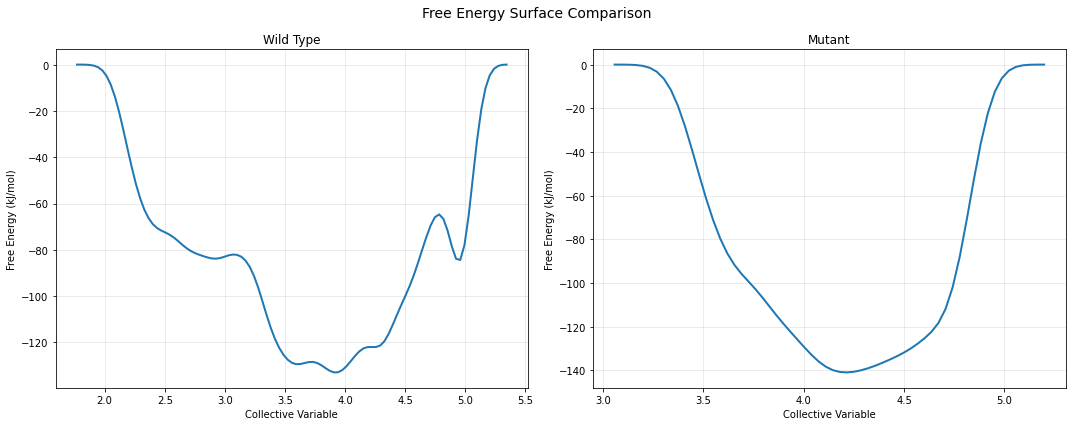

In [8]:
# Создаем фигуру с двумя субплотами
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Загружаем и строим первый график
data_1d_wild = np.loadtxt('real_wildtype.dat')
ax1.plot(data_1d_wild[:, 0], data_1d_wild[:, 1], linewidth=2)
ax1.set_xlabel('Collective Variable')
ax1.set_ylabel('Free Energy (kJ/mol)')
ax1.set_title('Wild Type')
ax1.grid(True, alpha=0.3)

# Загружаем и строим второй график
data_1d_mutant = np.loadtxt('real_mutant.dat')
ax2.plot(data_1d_mutant[:, 0], data_1d_mutant[:, 1], linewidth=2)
ax2.set_xlabel('Collective Variable')
ax2.set_ylabel('Free Energy (kJ/mol)')
ax2.set_title('Mutant')
ax2.grid(True, alpha=0.3)

# Добавляем общий заголовок
fig.suptitle('Free Energy Surface Comparison', fontsize=14)

# Регулируем расстояние между графиками
plt.tight_layout()

plt.show()

### На основе перевзвешенных данных:
`plumed driver --plumed rew.dat --noatoms`

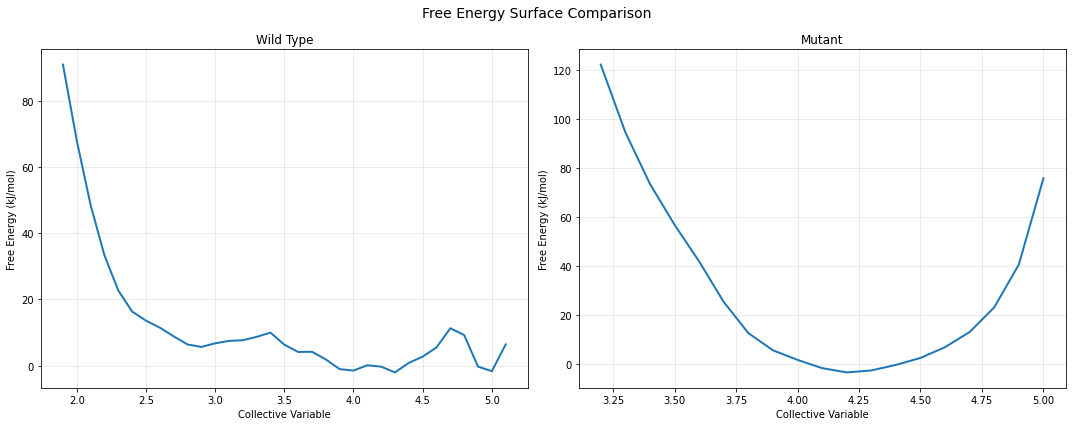

In [9]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

data_1d_wild = np.loadtxt('real_wildtype_fes.dat')
ax1.plot(data_1d_wild[:, 0], data_1d_wild[:, 1], linewidth=2)
ax1.set_xlabel('Collective Variable')
ax1.set_ylabel('Free Energy (kJ/mol)')
ax1.set_title('Wild Type')
ax1.grid(True, alpha=0.3)

data_1d_mutant = np.loadtxt('real_mutant_fes.dat')
ax2.plot(data_1d_mutant[:, 0], data_1d_mutant[:, 1], linewidth=2)
ax2.set_xlabel('Collective Variable')
ax2.set_ylabel('Free Energy (kJ/mol)')
ax2.set_title('Mutant')
ax2.grid(True, alpha=0.3)

fig.suptitle('Free Energy Surface Comparison', fontsize=14)

plt.tight_layout()

plt.show()

### Радиус гирации
Расчитала радиус гирации и объединила данные COLVAR и значения радиуса гирации:

In [17]:
data = pd.read_csv('COLVAR_combined_real_wildtype', delim_whitespace=True)
data

/tmp/ipykernel_20086/2631675590.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('COLVAR_combined_real_wildtype', delim_whitespace=True)


,time,afscore,metad.bias,metad.rbias,rg
0,0.0,4.976209,0.000000,0.000000,0.712185
1,1.0,4.980226,0.000000,0.000000,0.717956
2,2.0,4.979177,0.498628,0.485108,0.719796
3,3.0,4.983649,0.983289,0.954131,0.724532
4,4.0,4.963094,1.427673,1.380492,0.721678
...,...,...,...,...,...
9996,9996.0,2.787379,56.126295,-8.427924,0.868196
9997,9997.0,2.805650,56.222387,-8.331686,0.884934
9998,9998.0,2.798494,56.201935,-8.352000,0.866023
9999,9999.0,2.799257,56.225428,-8.328367,0.874063


Дальше идут очень плохие графики, они получены ошибочно:

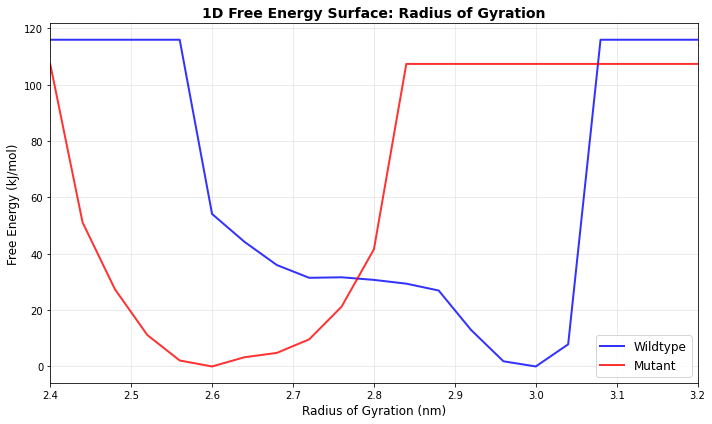

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def load_fes_1d_rg(filename):
    """Загружает 2D FES файл и преобразует в 1D FES по радиусу гирации"""
    try:
        with open(filename, 'r') as f:
            # Читаем параметры сетки
            for line in f:
                if line.startswith('#! SET min_af'):
                    min_af = float(line.split()[-1])
                elif line.startswith('#! SET max_af'):
                    max_af = float(line.split()[-1])
                elif line.startswith('#! SET nbins_af'):
                    nbins_af = int(line.split()[-1])
                elif line.startswith('#! SET min_rg'):
                    min_rg = float(line.split()[-1])
                elif line.startswith('#! SET max_rg'):
                    max_rg = float(line.split()[-1])
                elif line.startswith('#! SET nbins_rg'):
                    nbins_rg = int(line.split()[-1])
                elif not line.startswith('#'):
                    break
        
        # Загружаем данные
        data = np.loadtxt(filename)
        
        # Извлекаем колонки
        af = data[:, 0]    # AlphaFold score
        rg = data[:, 1]    # Radius of gyration
        fes = data[:, 2]   # Free energy
        
        # Решаем проблему с inf значениями
        fes_clean = np.copy(fes)
        fes_clean[np.isinf(fes)] = np.nan
        
        # Преобразуем в 2D сетку
        fes_grid = fes_clean.reshape(nbins_af + 1, nbins_rg + 1)
        rg_grid = rg.reshape(nbins_af + 1, nbins_rg + 1)
        
        # Создаем координатные оси
        rg_axis = np.linspace(min_rg, max_rg, nbins_rg + 1)
        
        # Вычисляем 1D FES по Rg (интегрируем по AlphaFold score)
        fes_1d_rg = np.zeros(nbins_rg + 1)
        
        for i in range(nbins_rg + 1):
            # Берем все значения FES для данного Rg (по всем AlphaFold score)
            fes_values = fes_grid[:, i]
            
            # Исключаем inf и очень большие значения
            valid_fes = fes_values[fes_values < 50]
            
            if len(valid_fes) > 0:
                # Используем формулу: FES_1d = -kT * ln(∑ exp(-FES_2d/kT))
                # При T=300K, kT ≈ 2.494 kJ/mol
                kT = 2.494
                boltzmann_sum = np.sum(np.exp(-valid_fes / kT))
                if boltzmann_sum > 0:
                    fes_1d_rg[i] = -kT * np.log(boltzmann_sum)
                else:
                    fes_1d_rg[i] = 100  # Большое значение если сумма нулевая
            else:
                fes_1d_rg[i] = 100
        
        # Нормализуем минимальную энергию к 0
        min_fes = np.min(fes_1d_rg[fes_1d_rg < 50])
        fes_1d_rg_norm = fes_1d_rg - min_fes
        
        return rg_axis, fes_1d_rg_norm
        
    except Exception as e:
        print(f"Ошибка загрузки {filename}: {e}")
        return None, None

# Создаем график
plt.figure(figsize=(10, 6))

# Загружаем и строим Wildtype
rg_wt_1d, fes_wt_1d = load_fes_1d_rg('rev-fes_2d_real_wildtype.dat')
if fes_wt_1d is not None:
    plt.plot(rg_wt_1d, fes_wt_1d, 'b-', linewidth=2, label='Wildtype', alpha=0.8)

# Загружаем и строим Mutant
rg_mut_1d, fes_mut_1d = load_fes_1d_rg('rev-fes_2d_real_mutant.dat')
if fes_mut_1d is not None:
    plt.plot(rg_mut_1d, fes_mut_1d, 'r-', linewidth=2, label='Mutant', alpha=0.8)

# Настраиваем график
plt.xlabel('Radius of Gyration (nm)', fontsize=12)
plt.ylabel('Free Energy (kJ/mol)', fontsize=12)
plt.title('1D Free Energy Surface: Radius of Gyration', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Устанавливаем пределы если нужно
plt.xlim(2.4, 3.2)
#plt.ylim(0, 25)

plt.tight_layout()
plt.show()


Приходим к печальному выводу, что наш мутант гораздо хуже держит форму, в то время как нативный белок сохраняет низкие значения энергии на более высоких значениях радиуса гирации

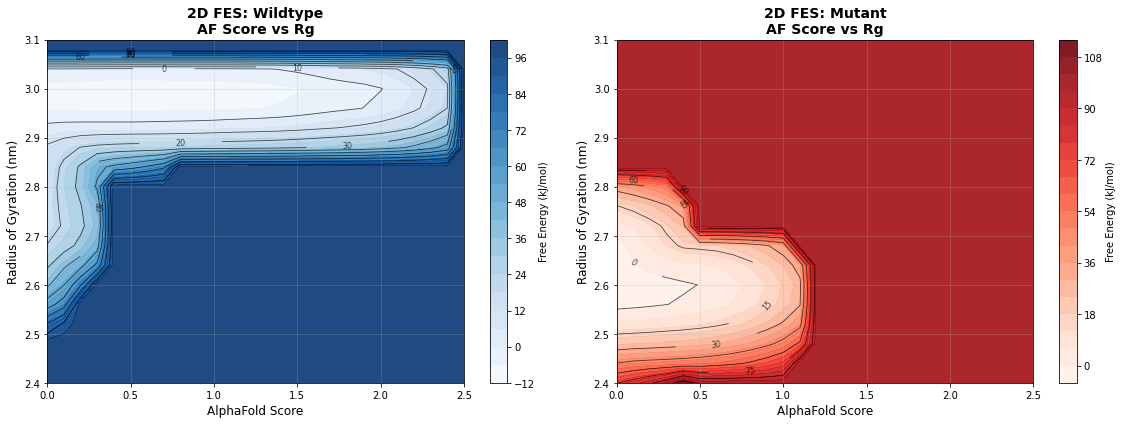

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def load_fes_2d_corrected(filename):
    """Загружает 2D FES файл с правильной структурой"""
    try:
        with open(filename, 'r') as f:
            # Читаем параметры сетки
            for line in f:
                if line.startswith('#! SET min_af'):
                    min_af = float(line.split()[-1])
                elif line.startswith('#! SET max_af'):
                    max_af = float(line.split()[-1])
                elif line.startswith('#! SET nbins_af'):
                    nbins_af = int(line.split()[-1])
                elif line.startswith('#! SET min_rg'):
                    min_rg = float(line.split()[-1])
                elif line.startswith('#! SET max_rg'):
                    max_rg = float(line.split()[-1])
                elif line.startswith('#! SET nbins_rg'):
                    nbins_rg = int(line.split()[-1])
                elif not line.startswith('#'):
                    break
        
        # Загружаем данные
        data = np.loadtxt(filename)
        
        # Извлекаем колонки
        af = data[:, 0]    # AlphaFold score
        rg = data[:, 1]    # Radius of gyration
        fes = data[:, 2]   # Free energy
        
        # Решаем проблему с inf значениями
        fes_clean = np.copy(fes)
        fes_clean[np.isinf(fes)] = 100
        
        # Правильное разрешение в 2D сетку (101x101)
        af_grid = af.reshape(nbins_af + 1, nbins_rg + 1)
        rg_grid = rg.reshape(nbins_af + 1, nbins_rg + 1)
        fes_grid = fes_clean.reshape(nbins_af + 1, nbins_rg + 1)
        
        # Создаем координатные оси
        af_axis = np.linspace(min_af, max_af, nbins_af + 1)
        rg_axis = np.linspace(min_rg, max_rg, nbins_rg + 1)
        
        return af_grid, rg_grid, fes_grid
        
    except Exception as e:
        print(f"Ошибка загрузки {filename}: {e}")
        return None, None, None

# Создаем фигуру с двумя субплогами
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Загружаем и строим Wildtype
#print("Загружаем Wildtype данные...")
af_wt, rg_wt, fes_wt = load_fes_2d_corrected('rev-fes_2d_real_wildtype.dat')

if fes_wt is not None:
    # Очищаем данные (заменяем inf и большие значения)
    fes_wt_clean = np.copy(fes_wt)
    #fes_wt_clean[np.isinf(fes_wt)] = np.nan
    #fes_wt_clean[fes_wt_clean > 50] = np.nan
    
    # Нормализуем (минимальная энергия = 0)
    #min_fes_wt = np.nanmin(fes_wt_clean)
    #fes_wt_norm = fes_wt_clean - min_fes_wt
    
    # Строим контурный график
    contour1 = ax1.contourf(af_wt, rg_wt, fes_wt_clean.T, 
                           levels=20, cmap='Blues', alpha=0.9)
    
    # Добавляем контурные линии
    CS1 = ax1.contour(af_wt, rg_wt, fes_wt_clean.T, 
                     levels=10, colors='black', linewidths=0.8, alpha=0.7)
    ax1.clabel(CS1, inline=True, fontsize=8, fmt='%1.0f')
    
    ax1.set_xlabel('AlphaFold Score', fontsize=12)
    ax1.set_ylabel('Radius of Gyration (nm)', fontsize=12)
    ax1.set_title('2D FES: Wildtype\nAF Score vs Rg', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Цветовая шкала
    plt.colorbar(contour1, ax=ax1, label='Free Energy (kJ/mol)')

# Загружаем и строим Mutant
#print("\nЗагружаем Mutant данные...")
af_mut, rg_mut, fes_mut = load_fes_2d_corrected('rev-fes_2d_real_mutant.dat')
if fes_mut is not None:
    # Очищаем данные
    fes_mut_clean = np.copy(fes_mut)
    #fes_mut_clean[np.isinf(fes_mut)] = np.nan
    #fes_mut_clean[fes_mut_clean > 50] = np.nan
    
    # Нормализуем
    #min_fes_mut = np.nanmin(fes_mut_clean)
    #fes_mut_norm = fes_mut_clean - min_fes_mut
    
    # Строим контурный график
    contour2 = ax2.contourf(af_mut, rg_mut, fes_mut_clean.T, 
                           levels=20, cmap='Reds', alpha=0.9)
    
    # Добавляем контурные линии
    CS2 = ax2.contour(af_mut, rg_mut, fes_mut_clean.T, 
                     levels=10, colors='black', linewidths=0.8, alpha=0.7)
    ax2.clabel(CS2, inline=True, fontsize=8, fmt='%1.0f')
    
    ax2.set_xlabel('AlphaFold Score', fontsize=12)
    ax2.set_ylabel('Radius of Gyration (nm)', fontsize=12)
    ax2.set_title('2D FES: Mutant\nAF Score vs Rg', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Цветовая шкала
    plt.colorbar(contour2, ax=ax2, label='Free Energy (kJ/mol)')

# Настраиваем общий вид

ax1.set_xlim(0, 2.5)
ax1.set_ylim(2.4, 3.1)
ax2.set_xlim(0, 2.5)
ax2.set_ylim(2.4, 3.1)

plt.tight_layout()
plt.savefig('2d_fes_comparison.png', dpi=300, bbox_inches='tight')
plt.show()